## initialisation 

regles de codage : 

type_nom_variable
nomFonction(...) 

aeroport ipv airports 
vol --> routesANLO --> df_vols
routes --> dict_routes 

In [1]:
# pip install networkx 

# imports 
import pandas as pd
import numpy as np
import ipywidgets as widgets
import networkx as nx
import matplotlib.pyplot as plt


# databases 
airports_df = pd.read_csv("../data/aeroportsANLO.csv")
routes_df = pd.read_csv("../data/routesANLO.csv")
continents_df = pd.read_csv("../data/countries.csv")

# conversion to dict continent 
continents_dict = dict(zip(continents_df['country'], continents_df['continent'])); del continents_df


In [2]:
# TODO doit etre possible plus vite 
airports_dict = dict()
for row in airports_df[['Iata','Name','Country']].iterrows():
    a = row[1][0]
    b = row[1][1]
    c = row[1][2]
    airports_dict[a] = dict(zip(['Name','Country'], [b,c]))
del a, b ,c

In [3]:
r1 = routes_df[routes_df['Depart'] == 'KWE']['Arrivee']
r2 = routes_df[routes_df['Arrivee'] == 'AMS']['Depart']
resultat = pd.merge(r1, r2,left_on = 'Arrivee', right_on = 'Depart')['Depart'].unique()

In [4]:
# optie 2
def correspondance_1airport_int(code1 : str, code2 : str):
    r1 = routes_df[routes_df['Depart'] == code1]['Arrivee'].to_list()
    r2 = routes_df[routes_df['Arrivee'] == code2]['Depart'].to_list()

    return list(set(r1).intersection(r2))

##  Graphe airports - functions 

In [1]:
def creation_edges_am(graphe : nx.Graph, listReference : list, code1 : str, code2 : str):
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        et les ajouts dans le graph donne en parametre 
        retour : list des edges ajoute a la graphe [(start , end, weight), (start, end ,weight ) .. ]
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    listConnections = correspondance_1airport_int(code1, code2)
    # pour gerer les correspondances 
    if listReference.count(code1) == 0: listReference.append(code1); 
    if listReference.count(code2) == 0: listReference.append(code2)
    
    for i in listConnections :
        if listReference.count(i) == 0 : 
            listReference.append(i)     
    
    index1 = listReference.index(code1) 
    index2 = listReference.index(code2)
    weight = 2  # TODO calculer le C02 par rapport a la distance  
   
    listEdges = list(map(lambda x : (index1, listReference.index(x), weight), listConnections))
    listEdges.extend(list(map(lambda y : (listReference.index(y), index2, weight), listConnections)))
    
    graphe.add_weighted_edges_from(listEdges)
    return listEdges

NameError: name 'nx' is not defined

In [6]:
# version orginale 
# besoin d'une grande list qui rappel tous chiffre avec les codes des airports  
def creation_edges_orgin(graphe : nx.Graph, listReference : list, code1 : str, code2 : str): #returnListEdges :list[tuple]
    '''
        fonction qui crée à partir d'une liste d'aéroports un list des edges d'une graphe (avec le weight)
        
    '''
    # dans le listReference les airport recois un index qui corresponds au identifiant de graphe 
    listConnections = correspondance_1airport_int(code1, code2)
    # pour gerer les correspondances 
    if listReference.count(code1) == 0:
        listReference.append(code1); #  airport de depart 
    
    index1 = listReference.index(code1); 
    
    for i in listConnections :
        if listReference.count(i) == 0 : 
            listReference.append(i)     
    
    if listReference.count(code2) == 0:
        listReference.append(code2); # fin list => airport de  arrivee
    
    index2 = listReference.index(code2)
    
    listEdges = []
    for i in listConnections : 
        weight = 2 # TODO doit etre remplacee par distance 
        
        indextmp = listReference.index(i)
        listEdges.append((index1,indextmp,weight))
        listEdges.append((indextmp,index2,weight))

    graphe.add_weighted_edges_from(listEdges)
    return listEdges

In [7]:
def dessiner_graphe(nom_graphe):
 
    pos = nx.fruchterman_reingold_layout(nom_graphe)
    nx.draw_networkx_nodes(nom_graphe, pos, node_size = 200)
    nx.draw_networkx_edges(nom_graphe,pos, edgelist= nom_graphe.edges(), edge_color='black')
    nx.draw_networkx_labels(nom_graphe, pos)
    plt.autoscale()
    #plt.title((code1,code2))
    #nx.draw_networkx_edge_labels(nom_graphe, pos) # afficher le weight 

    plt.show()

In [8]:
def conversion(listOfEdgesWeighted : list[tuple], graphe : nx.Graph):
    '''
        function qui convertie un list avec les edges d'uin graph avec leur "weight" et 
        qui le convertie en une dict de graph qui peut être utilise par le algorithme de dijkstra 
        retour : le dict qui represente une graphe sous forme de { ind_start : [(end, weight) , (end, weight)], ind_start : [ ..] etc }
    '''
    # calculer le nombre de nodes 
    nbNodes = graphe.number_of_nodes()
    
    # creation d'une dict avec le nombre de nodes initialise avec une liste vide 
    returnDict= dict()
    
    for i in range(0,nbNodes):         
        returnDict[i] = []

    # remplir le dictionairy a partir de listOfEdgesWeighted
    for t in listOfEdgesWeighted:
        # on doit ajoute les edges dans les deux cote (de 1 --> 2 et de 2 --> 1)
        returnDict[t[0]].append((t[1],t[2])) 
        returnDict[t[1]].append((t[0],t[2])) 
        
    return returnDict

## AAL --> LNZ

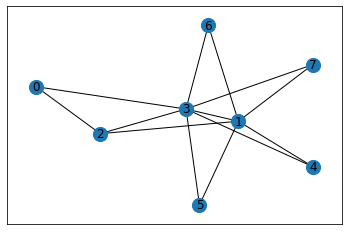

{0: [(2, 2), (3, 2)],
 1: [(2, 2), (3, 2), (4, 2), (5, 2), (2, 2), (6, 2), (7, 2)],
 2: [(0, 2), (1, 2), (1, 2), (3, 2)],
 3: [(0, 2), (1, 2), (4, 2), (5, 2), (2, 2), (6, 2), (7, 2)],
 4: [(1, 2), (3, 2)],
 5: [(1, 2), (3, 2)],
 6: [(1, 2), (3, 2)],
 7: [(1, 2), (3, 2)]}

In [9]:
# werkt voor 'AAL' naar 'LNZ'
graphe_test = nx.Graph()
returnlist = []
conlist = creation_edges_am(graphe_test, returnlist, 'AAL', 'LNZ')

conlist.extend(creation_edges_am(graphe_test, returnlist, returnlist[1], returnlist[3] ))

dessiner_graphe(graphe_test)
conversion(conlist, graphe_test)  # ce list peut etre utilise par algorithm de dijkstra 

In [10]:
# Notities 
# all the edges
#print("weighted edges : ")
#print(rList) 
# rList.sort(key= lambda a : a[0]) 
#print("edges coordinaat : ")
#conversion_test = [e for e in graphe_test2.edges] # list of edges 
#[e for e in graphe_test2.edges] # list of nodes 
#graphe_test2.number_of_edges() # number of edges 
#graphe_test2.number_of_nodes() # number of edges 

## AAL --> LAX

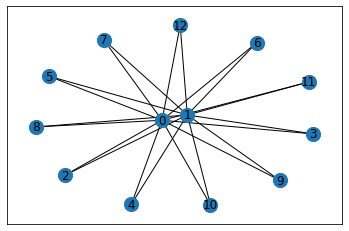

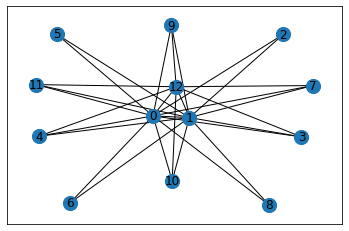

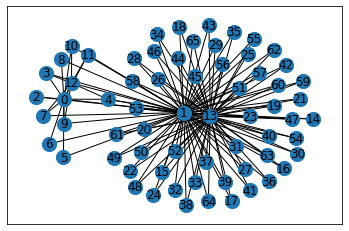

In [11]:
# test 3 
graphe_test3 = nx.Graph()
list_test3 = []
test3 = creation_edges_am(graphe_test3, list_test3, 'AAL', 'AMS')

dessiner_graphe(graphe_test3)
new_code1 = list_test3[0]
new_code2 = list_test3[12]
# si on reutilise le list_test3 on peu aggrandir notre carte, et du coup ajoute des correspondances 
test3.extend(creation_edges_am(graphe_test3, list_test3, new_code1, new_code2))
dessiner_graphe(graphe_test3)
test3.extend(creation_edges_am(graphe_test3, list_test3, 'AMS', 'LAX'))
dessiner_graphe(graphe_test3)


#conversion(test3+test33, graphe_test3)
# on peut recupere le nom d'une airport intermediare par appele pour utilise list_test3[nb_node]

## AAR --> ANR 

In [12]:
# test creation_edges vs creation_edges_am 
import time 

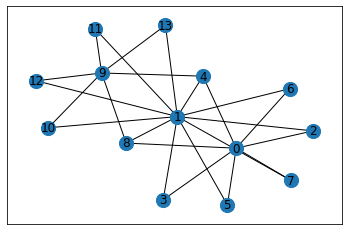

0.42200803756713867


In [13]:
#test creation_edges 
start1 = time.time()

graph_test4_1 = nx.Graph(); 
ref_test4_1 = []
# creer une correspondance 
test_time1 = creation_edges_am(graph_test4_1, ref_test4_1, 'AAR', 'DUS')
test_time1.extend(creation_edges_am(graph_test4_1, ref_test4_1, 'DUS', 'ANR'))

dessiner_graphe(graph_test4_1)

end1 = time.time()
print( end1 - start1)

#conversion(ttt+tt, graph_test4_1)

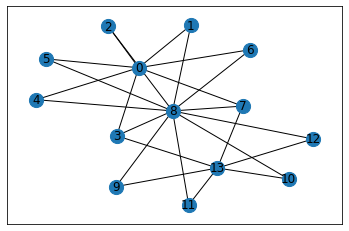

0.43059253692626953


In [14]:
#test creation_edges 
start = time.time()
graph_test4_2 = nx.Graph(); 
ref_test4_2 = []

# creer une correspondance 
test_time2 = creation_edges_orgin(graph_test4_2, ref_test4_2, 'AAR', 'DUS')
test_time2.extend(creation_edges_orgin(graph_test4_2, ref_test4_2, 'DUS', 'ANR'))

dessiner_graphe(graph_test4_2)

end = time.time()
print( end - start)

#conversion(test_time2, graph_test4_2)

### test different graphe vis

In [15]:
#pip install pyvis
from pyvis.network import Network
net = Network()

g = net.from_nx(graphe_test3)
net.show_buttons(filter_=['physics'])
net.show("test.html")


# Dijkstra algorithme try 1 
inspiration from https://pythonalgos.com/dijkstras-algorithm-in-5-steps-with-python/
number node => code_airport , 
distance => ecoprint 


https://coderzcolumn.com/tutorials/data-science/network-analysis-in-python-node-importance-and-paths-networkx#4.1

In [16]:
from numpy import Inf
import heapq

In [17]:
def lazy_dijkstras(graph, root):
    n = len(graph)
    # set up "inf" distances
    dist = [Inf for _ in range(n)]
    # set up root distance
    dist[root] = 0
    # set up visited node list
    visited = [False for _ in range(n)]
    # set up priority queue
    pq = [(0, root)]
    # while there are nodes to process
    while len(pq) > 0:
        # get the root, discard current distance
        _, u = heapq.heappop(pq)
        # if the node is visited, skip
        if visited[u]:
            continue
        # set the node to visited
        visited[u] = True
        # check the distance and node and distance
        for v, l in graph[u]:
            # if the current node's distance + distance to the node we're visiting
            # is less than the distance of the node we're visiting on file
            # replace that distance and push the node we're visiting into the priority queue
            if dist[u] + l < dist[v]:
                dist[v] = dist[u] + l
                heapq.heappush(pq, (dist[v], v))
    return dist

In [18]:
graph_test_nb = { # form needed for dijkstra
    0: [(1, 5), (2, 1)],
    1: [(0, 5), (3, 2)],
    2: [(0, 1), (3, 1)],
    3: [(1, 4), (2, 1)]
}

In [19]:
#print(naive_dijkstras(graph,1))
lazy_dijkstras(graph_test_nb, 0) #[0, 5, 1, 2]

# cela veut dire que 
#    | AAL|LPA |DUS |LNZ|
# AAL  0  |  5 | 1  | 2 |
# conclusion de AAL à LNZ le plus courte chemin est 2

[0, 5, 1, 2]